### Imports ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import imageio
import os

### Grid and World creation ###

In [114]:
class Grid:
    def __init__(self, p=0.5, SIZE=11):
        self._p = p
        self.state = {'fire': 3, 'forest': 2, 'ash':1, 'empty':0}
        self.shape = np.array([SIZE, SIZE])
        self._grid = np.random.choice(3, SIZE*SIZE , p = [1-p, 0, p]).reshape((SIZE, SIZE))
        self._grid[SIZE//2,SIZE//2] = self.state['fire']
        self._newGrid = self._grid.copy()
        self._numberOfForestInit = self.getNumberOfKey()
        self.palette = np.array([[212,212,212],     # empty
                    [125,72,76],      # ash 
                    [0,170,0],       # forest
                   [240,8,24]])     # fire
    def getNumberOfKey(self, key = 2):
        return np.count_nonzero(self._grid == key)
    
    def _find_neighbors(self, pos):
        l = pos[0]
        c = pos[1]
        neighbors = []
        for L in range(-1,2):
            for C in range(-1,2):
                if L!=0 or C!=0:
                    if not(l+L == -1 or l+L > self.shape[0]-1 or c+C == -1 or c+C > self.shape[1]-1):
                        neighbors.append(np.array([l+L, c+C]))
        return neighbors
    
    def ignite(self, pos):
        if self._grid[pos[0],pos[1]] == self.state['forest']:
            self._newGrid[pos[0],pos[1]] = self.state['fire']
            
    def isBurning(self, pos):
        if self._grid[pos[0],pos[1]] == self.state['fire']:
            return True
        else: 
            return False
        
    def isNearFire(self, pos):
        isNearFire = False
        for neigh in self._find_neighbors(pos):
            if self._grid[neigh[0], neigh[1]] == self.state['fire']:
                isNearFire = True
        return isNearFire
        
    def turn_to_ash(self, pos):
        self._newGrid[pos[0],pos[1]] = self.state['ash']
        
    def switch_grid(self):
        self._grid = self._newGrid.copy()
        
    def isStillBurning(self):
        nb_fire = len(np.where(self._grid == self.state['fire'])[0])
        if nb_fire==0:
            return False
        else:
            return True
    def draw_grid(self):
        plt.title('p={}'.format(self._p)) 
        plt.imshow(self.palette[self._grid])
        
    def save_grid(self, epochs):
        output_file = '%s.jpg' % datetime.datetime.now()#.strftime('%Y-%M-%d-%H-%M-%S')
        plt.title('p={} epochs={}'.format(self._p, epochs)) 
        plt.imshow(self.palette[self._grid])
        plt.savefig(output_file,bbox_inches='tight', dpi=75)

nb forest 56


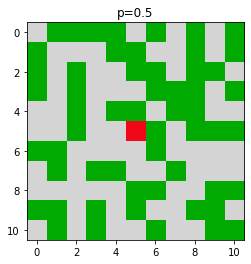

In [120]:
g = Grid()
g.draw_grid()

print("nb forest", g.getNumberOfKey())

In [139]:
class World:
    def __init__(self, p=0.5, SIZE = 31):
        self.grid = Grid(p, SIZE)
        self.epochs_before_death = 0

        
    def one_round(self):
        sizeL = self.grid.shape[0]
        sizeC = self.grid.shape[1]
        for l in range(sizeL):
            for c in range(sizeC):
                pos = (l,c)
                if self.grid.isBurning(pos):
                    self.grid.turn_to_ash(pos)
                elif self.grid.isNearFire(pos):
                    self.grid.ignite(pos)        
        self.grid.switch_grid()
        
    def until_ash(self, save_plot = False):
        stillBruning = True
        epochs = 1
        while stillBruning and epochs < 300:
            if save_plot:
                self.save(epochs)
            self.one_round()
            stillBruning = self.grid.isStillBurning()
            epochs += 1
        self.epochs_before_death = epochs-1
        return self.epochs_before_death, (1-self.grid.getNumberOfKey()/self.grid._numberOfForestInit)
        
    def draw(self):
        self.grid.draw_grid()
        
    def save(self, epochs=0):
        self.grid.save_grid(epochs)
        
    def create_gif(self, path='.', duration=0.5):
        images = []
        for filename in os.listdir(path):
            #print(filename)
            if filename[-3:] == 'jpg':
                images.append(filename)                
        if len(images) != 0:
            images.sort()
            imagesIo = []
            for im in images:
                imagesIo.append(imageio.imread(im))
                os.remove(im)
            output_file = 'Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
            imageio.mimsave(output_file, imagesIo, duration=duration)

### Making stats ###

In [144]:
percolations = np.arange(0.45, 0.65, 0.05 )
SIZES = np.arange(31, 61, step=10)
N = 5
data = {}
for SIZE in SIZES:
    data[SIZE,'epoch'] = np.array([])
    data[SIZE,'%forestAlive'] = np.array([])
    for p in percolations:
        dataEpoch = np.array([])
        dataForest = np.array([])
        for i in range(N):
            w = World(p=p, SIZE=SIZE)
            epoch, PerforestAlive = w.until_ash()
            dataEpoch = np.append(dataEpoch, epoch) 
            dataForest = np.append(dataForest, PerforestAlive) 
            #w.create_gif()
        data[SIZE,'epoch'] = np.append(data[SIZE,'epoch'], dataEpoch.mean())
        data[SIZE,'%forestAlive'] = np.append(data[SIZE,'%forestAlive'], dataForest.mean())
        #tab[(SIZE,p)] = w.epochs_before_death
#print("epochs need before end of fire: {}".format(epochs_need))

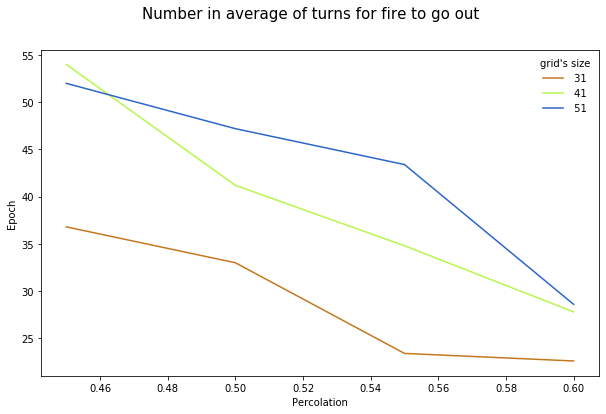

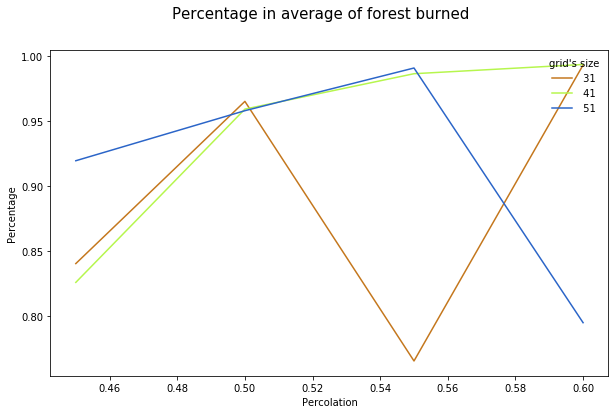

In [145]:
# Initialise the figure and axes.
fig1, ax1 = plt.subplots(1, figsize=(10, 6))
fig2, ax2 = plt.subplots(1, figsize=(10, 6))

# Set the title for the figure
fig1.suptitle('Number in average of turns for fire to go out', fontsize=15)
fig2.suptitle('Percentage in average of forest burned', fontsize=15)

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend.
for size in SIZES:
    rgb = np.random.rand(3)
    ax1.plot(percolations, data[size,'epoch'], color=rgb, label=" {}".format(size))
    ax2.plot(percolations, data[size, '%forestAlive'], color=rgb, label=" {}".format(size))
plt.figure(1)
plt.xlabel('Percolation')
plt.ylabel('Epoch')
# Add a legend, and position it on the lower right (with no box)
plt.legend(loc="upper right", title="grid's size", frameon=False)

plt.figure(2)
plt.xlabel('Percolation')
plt.ylabel('Percentage')
plt.legend(loc="upper right", title="grid's size", frameon=False)

plt.show()

In [80]:
np.random.rand(3)

array([0.91869488, 0.9570751 , 0.88414162])